In [ ]:
### Import standard libraries

import abc
from dataclasses import dataclass
import functools
from functools import partial
import itertools
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Callable, NamedTuple, Optional, Union, Tuple

import jax
import jax.numpy as jnp
from jax import lax, vmap, jit, grad
#from jax.scipy.special import logit
#from jax.nn import softmax
import jax.random as jr



import distrax
import optax

import jsl
import ssm_jax

import inspect
import inspect as py_inspect
import rich
from rich import inspect as r_inspect
from rich import print as r_print

def print_source(fname):
    r_print(py_inspect.getsource(fname))

(sec:lds-intro)=
# Linear Gaussian SSMs


Consider the state space model in 
{eq}`eq:SSM-ar`
where we assume the observations are conditionally iid given the
hidden states and inputs (i.e. there are no auto-regressive dependencies
between the observables).
We can rewrite this model as 
a stochastic $\keyword{nonlinear dynamical system}$ or $\keyword{NLDS}$
by defining the distribution of the next hidden state 
$\hidden_t \in \real^{\nhidden}$
as a deterministic function of the past state
$\hidden_{t-1}$,
the input $\inputs_t \in \real^{\ninputs}$,
and some random $\keyword{process noise}$ $\transNoise_t \in \real^{\nhidden}$ 
\begin{align}
\hidden_t &= \dynamicsFn(\hidden_{t-1}, \inputs_t, \transNoise_t)  
\end{align}
where $\transNoise_t$ is drawn from the distribution such
that the induced distribution
on $\hidden_t$ matches $p(\hidden_t|\hidden_{t-1}, \inputs_t)$.
Similarly we can rewrite the observation distribution
as a deterministic function of the hidden state
plus $\keyword{observation noise}$ $\obsNoise_t \in \real^{\nobs}$:
\begin{align}
\obs_t &= \measurementFn(\hidden_{t}, \inputs_t, \obsNoise_t)
\end{align}


If we assume additive Gaussian noise,
the model becomes
\begin{align}
\hidden_t &= \dynamicsFn(\hidden_{t-1}, \inputs_t) +  \transNoise_t  \\
\obs_t &= \measurementFn(\hidden_{t}, \inputs_t) + \obsNoise_t
\end{align}
where $\transNoise_t \sim \gauss(\vzero,\transCov_t)$
and $\obsNoise_t \sim \gauss(\vzero,\obsCov_t)$.
We will call these $\keyword{Gaussian SSMs}$.

If we additionally assume
the transition function $\dynamicsFn$
and the observation function $\measurementFn$ are both linear,
then we can rewrite the model as follows:
\begin{align}
p(\hidden_t|\hidden_{t-1},\inputs_t) &= \gauss(\hidden_t|\ldsDyn \hidden_{t-1}
+ \ldsDynIn \inputs_t, \transCov)
\\
p(\obs_t|\hidden_t,\inputs_t) &= \gauss(\obs_t|\ldsObs \hidden_{t}
+ \ldsObsIn \inputs_t, \obsCov)
\end{align}
This is called a 
$\keyword{linear-Gaussian state space model}$
or $\keyword{LG-SSM}$;
it is also called 
a $\keyword{linear dynamical system}$ or $\keyword{LDS}$.
We usually assume the parameters are independent of time, in which case
the model is said to be time-invariant or homogeneous.


(sec:tracking-lds)=
(sec:kalman-tracking)=
## Example: tracking a 2d point



% Sarkkar p43
Consider an object moving in $\real^2$.
Let the state be
the position and velocity of the object,
$\hidden_t =\begin{pmatrix} u_t & \dot{u}_t & v_t & \dot{v}_t \end{pmatrix}$.
(We use $u$ and $v$ for the two coordinates,
to avoid confusion with the state and observation variables.)
If we use Euler discretization,
the dynamics become
\begin{align}
\underbrace{\begin{pmatrix} u_t\\ \dot{u}_t \\ v_t \\ \dot{v}_t \end{pmatrix}}_{\hidden_t}
  = 
\underbrace{
\begin{pmatrix}
1 & 0 & \Delta & 0 \\
0 & 1 & 0 & \Delta\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
}_{\ldsDyn}

\underbrace{\begin{pmatrix} u_{t-1} \\ \dot{u}_{t-1} \\ v_{t-1} \\ \dot{v}_{t-1} \end{pmatrix}}_{\hidden_{t-1}}
+ \transNoise_t
\end{align}
where $\transNoise_t \sim \gauss(\vzero,\transCov)$ is
the process noise.
We assume
that the process noise is 
a white noise process added to the velocity components
of the state, but not to the location,
so $\transCov = \diag(0, q, 0, q)$.
This is known as a random accelerations model.
(See  {cite}`Sarkka13` p60 for a more accurate way
to convert the continuous time process to discrete time.)


Now suppose that at each discrete time point we
observe the location,
corrupted by  Gaussian noise.
Thus the observation model becomes
\begin{align}
\underbrace{\begin{pmatrix}  \obs_{1,t} \\  \obs_{2,t} \end{pmatrix}}_{\obs_t}
  &=
    \underbrace{
    \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
    \end{pmatrix}
    }_{\ldsObs}
    
\underbrace{\begin{pmatrix} u_t\\ \dot{u}_t \\ v_t \\ \dot{v}_t \end{pmatrix}}_{\hidden_t}    
 + \obsNoise_t
\end{align}
where $\obsNoise_t \sim \gauss(\vzero,\obsCov)$ is the observation noise.
We see that the observation matrix $\ldsObs$ simply ``extracts'' the
relevant parts  of the state vector.

Suppose we sample a trajectory and corresponding set
of noisy observations from this model,
$(\hidden_{1:T}, \obs_{1:T}) \sim p(\hidden,\obs|\params)$.
(We use diagonal observation noise,
$\obsCov = \diag(\sigma_1^2, \sigma_2^2)$.)
The results are shown below. 


In [30]:
key = jax.random.PRNGKey(314)
timesteps = 15
delta = 1.0
A = jnp.array([
    [1, 0, delta, 0],
    [0, 1, 0, delta],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

state_size, _ = A.shape
observation_size, _ = C.shape

Q = jnp.eye(state_size) * 0.001
R = jnp.eye(observation_size) * 1.0
# Prior parameter distribution
mu0 = jnp.array([8, 10, 1, 0]).astype(float)
Sigma0 = jnp.eye(state_size) * 1.0

from jsl.lds.kalman_filter import LDS, smooth, filter

lds = LDS(A, C, Q, R, mu0, Sigma0)
print(lds)



LDS(A=DeviceArray([[1., 0., 1., 0.],
             [0., 1., 0., 1.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32), C=DeviceArray([[1, 0, 0, 0],
             [0, 1, 0, 0]], dtype=int32), Q=DeviceArray([[0.001, 0.   , 0.   , 0.   ],
             [0.   , 0.001, 0.   , 0.   ],
             [0.   , 0.   , 0.001, 0.   ],
             [0.   , 0.   , 0.   , 0.001]], dtype=float32), R=DeviceArray([[1., 0.],
             [0., 1.]], dtype=float32), mu=DeviceArray([ 8., 10.,  1.,  0.], dtype=float32), Sigma=DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32), state_offset=None, obs_offset=None, nstates=4, nobs=2)


In [31]:
from jsl.demos.plot_utils import plot_ellipse

def plot_tracking_values(observed, filtered, cov_hist, signal_label, ax):
    timesteps, _ = observed.shape
    ax.plot(observed[:, 0], observed[:, 1], marker="o", linewidth=0,
            markerfacecolor="none", markeredgewidth=2, markersize=8, label="observed", c="tab:green")
    ax.plot(*filtered[:, :2].T, label=signal_label, c="tab:red", marker="x", linewidth=2)
    for t in range(0, timesteps, 1):
        covn = cov_hist[t][:2, :2]
        plot_ellipse(covn, filtered[t, :2], ax, n_std=2.0, plot_center=False)
    ax.axis("equal")
    ax.legend()

(7.24486608505249, 23.857812213897706, 8.0420747756958, 11.636079216003418)

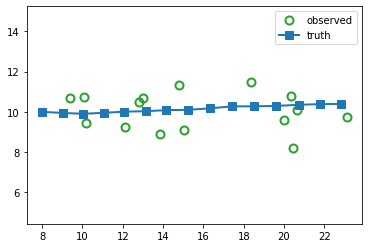

In [32]:

z_hist, x_hist = lds.sample(key, timesteps)

fig_truth, axs = plt.subplots()
axs.plot(x_hist[:, 0], x_hist[:, 1],
        marker="o", linewidth=0, markerfacecolor="none",
        markeredgewidth=2, markersize=8,
        label="observed", c="tab:green")

axs.plot(z_hist[:, 0], z_hist[:, 1],
        linewidth=2, label="truth",
        marker="s", markersize=8)
axs.legend()
axs.axis("equal")


The main task is to infer the hidden states given the noisy
observations, i.e., $p(\hidden_t|\obs_{1:t},\params)$
or $p(\hidden_t|\obs_{1:T}, \params)$ in the offline case.
We discuss the topic of inference in {ref}`sec:inference`.
We will usually represent this belief state by a Gaussian distribution,
$p(\hidden_t|\obs_{1:s},\params) = \gauss(\hidden_t| \mean_{t|s}, \covMat_{t|s})$,
where usually $s=t$ or $s=T$.
Sometimes we use information form, 
$p(\hidden_t|\obs_{1:s},\params) = \gaussInfo(\hidden_t|\precMean_{t|s}, \precMat_{t|s})$.